# Cross-Assay Integrative Analyses

In [5]:
import polars as pl
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from venn import venn
%matplotlib inline

## 1. Loading allele information

### 1.1 VarChAMP Dataset Alleles Merged with Pillar Project

In [14]:
varchamp_pillar_df = pl.read_csv("../../1_allele_collection/3_outputs/varchamp_alleles_with_pillar_annotations.tsv", 
                                 separator="\t", infer_schema_length=1000000)
print("VarChAMP dataset shape:", varchamp_pillar_df.shape)

VarChAMP dataset shape: (129900, 586)


In [15]:
varchamp_pillar_df.filter(pl.col("pillar_tested")).unique("symbol")

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""MSH2""","""ENSG00000095002""",7918,202639,"""CCSBVarC003004""","""ALE00003004""","""NC_000002.12:47408508:G:C""","""319G>C""","""Ala107Pro""","""CEGS2""","""CegsMutGDEh1046""","""A02""","""GDEhDisVCh_40060""","""B10""","""2""","""CegsMutGDDh1046""","""A02""","""NULL""","""NULL""","""VUSMutpDEST2_07""","""A03""","""NULL""","""NULL""",1,1,1,1,0,null,null,1,1,1,0,null,null,"""MSH2_Ala107Pro""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Ala107Pro""","""Ala107Pro""",true
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Asp""","""Ala148Asp""",true
"""ASPA""","""ENSG00000108381""",8459,15684,"""CCSBVarC001383""","""ALE00001383""","""NC_000017.11:3476230:A:G""","""71A>G""","""Glu24Gly""","""RC4""","""RC4_Mut_GDEh1016""","""D01""","""GDEhDisVCh_40040""","""C04""","""2""","""RC4_Mut_GDDh1016""","""D01""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,7,1,1,0,null,null,0,null,null,0,null,null,"""ASPA_Glu24Gly""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Glu24Gly""","""Glu24Gly""",true
"""CHEK2""","""ENSG00000183765""",4020,214978,"""CCSBVarC003836""","""ALE00003836""","""NC_000022.11:28725277:C:T""","""410G>A""","""Arg137Gln""","""CEGS2""","""CegsMutGDEh1016""","""D06""","""GDEhDisVCh_40025""","""B05""","""1""","""NULL""","""NU

In [16]:
varchamp_pillar_df["Interval 2 MaveDB class"]

Interval 2 MaveDB class
str
"""Normal"""
null
"""Normal"""
null
"""Normal"""
…
null
null
null


In [17]:
print("Overlapped unique gene variants between VarChAMP and Pillar Project:")
varchamp_pillar_df.filter(pl.col("pillar_tested")).unique("gene_variant")

Overlapped unique gene variants between VarChAMP and Pillar Project:


symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""F9""","""ENSG00000101981""",52861,204373,"""CCSBVarC004384""","""ALE00004384""","""NC_000023.11:139561602:A:G""","""917A>G""","""Asn306Ser""","""CEGS2""","""CegsMutGDEh1017""","""F07""","""GDEhDisVCh_40052""","""D03""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""F9_Asn306Ser""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Asn306Ser""","""Asn306Ser""",true
"""MSH2""",null,7918,null,"""CCSBVarC010846""",null,"""NC_000002.12:47410232:A:G""",null,"""Ile169Val""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Ile169Val""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Ile169Val""","""Ile169Val""",true
"""MSH2""","""ENSG00000095002""",7918,202677,"""CCSBVarC003012""","""ALE00003012""","""NC_000002.12:47470988:A:T""","""1685A>T""","""Glu562Val""","""CEGS2""","""CegsMutGDEh1041""","""A05""","""GDEhDisVCh_40060""","""C09""","""2""","""CegsMutGDDh1041""","""A05""","""NULL""","""NULL""","""VUSMutpDEST2_07""","""C04""","""NULL""","""NULL""",1,1,1,1,0,null,null,1,1,1,0,null,null,"""MSH2_Glu562Val""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""MSH2_Glu562Val""","""Glu562Val""",true
"""CHEK2""","""ENSG00000183765""",4020,214972,"""CCSBVarC003833""","""ALE00003833""","""NC_000022.11:28734546:G:T""","""176C>A""","""Thr59Lys""","""CEGS2""","""CegsMutGDEh101

In [18]:
pillar_clinvar_df = pl.read_csv(
    "../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
    pl.lit(True).alias("pillar_tested")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes Pillar ALL:", pillar_clinvar_df.unique(subset="Gene").shape[0])
print("Number of unique genes Pillar SNP:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Original pillar dataset shape: (1053945, 102)
Filtered missense/SNP pillar dataset shape: (121504, 104)
Number of unique genes Pillar ALL: 41
Number of unique genes Pillar SNP: 33
Number of unique gene variants: 61091


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,aa_change,pillar_tested
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,bool
27534,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
8857,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
27540,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Gly""","""Ala148Gly""",true
8863,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thyge

In [19]:
pillar_varchamp_df = pl.read_csv(
    "../../1_allele_collection/3_outputs/pillar_alleles_with_varchamp_annotations.tsv", 
    # schema_overrides={
    #     "Chrom": pl.String, 
    #     'aa_pos': pl.String, 
    #     'auth_reported_score': pl.String
    # },
    separator="\t",
    infer_schema_length=10000000
)
pillar_varchamp_df.shape

(1062282, 586)

### 1.2 Imaging Data

In [8]:
img_metric_df = pl.DataFrame()
img_metric_df = pl.read_csv("../1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
img_metric_df = img_metric_df.with_columns(
    pl.col("gene_allele").alias("gene_variant")
)
print("VarChAMP Imaging assay unique variants:", img_metric_df.unique(subset=["gene_variant"]).shape[0])

VarChAMP Imaging assay unique variants: 475


### 1.3 DUAL-IPA and PPI alleles

symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,…,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold,abund_zscore
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool,bool,f64,f64
"""KCNJ2""","""899G>A""","""Gly300Asp""","""KCNJ2_Gly300Asp""",693.679993,5069.049805,0.133067,0.841771,0.15808,-1.835174,-1.0,-5.882805,"""ENSG00000123700""","""CCSBVarC008343""","""ALE00008329""","""NC_000017.11:70175938:G:A""","""Edgotyping3""","""VUSMutGDEh010""","""G06""","""GDEhDisVCh_40005""","""F10""","""1""","""VUSMutGDDh010""","""G06""","""VUSN2Hmut_GDN2h_03""","""H09""","""VUSMutpDEST2_16""","""G04""","""VUSmut_GDEh03""","""H09""",1,2,1,2,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-5.882805
"""HBD""","""174C>A""","""Asn58Lys""","""HBD_Asn58Lys""",33.84,2474.280029,0.012192,0.077713,0.156882,-1.837623,-1.0,-5.907103,"""ENSG00000223609""","""CCSBVarC006560""","""ALE00006559""","""NC_000011.10:5234132:G:T""","""CEGS2""","""CegsMutGDEh1047""","""D02""","""GDEhDisVCh_40036""","""D03""","""2""","""CegsMutGDDh1047""","""D02""","""VUSN2Hmut_GDN2h_10""","""C04""","""VUSMutpDEST2_11""","""H05""","""VUSmut_GDEh10""","""C04""",1,1,1,1,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-5.907103
"""SMAD3""","""376C>T""","""His126Tyr""","""SMAD3_His126Tyr""",993.600037,3757.339966,0.267095,1.033889,0.25834,-1.630252,-1.0,-4.313822,"""ENSG00000166949""","""CCSBVarC007714""","""ALE00007700""","""NC_000015.10:67165064:C:T""","""Edgotyping3""","""VUSMutGDEh004""","""D11""","""GDEhDisVCh_40014""","""D06""","""2""","""VUSMutGDDh004""","""D11""","""NULL""","""NULL""","""VUSMutpDEST2_09""","""B02""","""NULL""","""NULL""",1,1,1,1,0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-4.313822
"""HBD""","""110C>A""","""Pro37His""","""HBD_Pro37His"

VarChAMP DUAL-IPA assay unique variants: 741


gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,i64,i64,i64,i64,f64,f64,f64,f64,i64,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""GFAP_Glu207Gln""",15,5,1,0,33.33,6.67,0.0,100.0,15,0.0,true,"""GFAP""","""ENSG00000131095""",2920,5180,"""CCSBVarC000366""","""ALE00000366""","""NC_000017.11:44913430:C:G""","""619G>C""","""Glu207Gln""","""RC4""","""RC4_Mut_GDEh1021""","""E06""","""GDEhDisVCh_40051""","""B12""","""1""","""RC4_Mut_GDDh1021""","""E06""","""NULL""","""NULL""","""VUSMutpDEST2_02""","""D11""","""NULL""","""NULL""",1,2,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""AGXT_Arg111Gln""",7,0,0,1,0.0,0.0,14.29,85.71,6,1.0003,true,"""AGXT""","""ENSG00000172482""",70497,3812,"""CCSBVarC008181""","""ALE00008167""","""NC_000002.12:240869336:G:A""","""332G>A""","""Arg111Gln""","""Edgotyping3""","""VUSMutGDEh004""","""G02""","""GDEhDisVCh_40002""","""G04""","""2""","""VUSMutGDDh004""","""G02""","""VUSN2Hmut_GDN2h_01""","""F06""","""VUSMutpDEST2_14""","""A04""","""VUSmut_GDEh01""","""F06""",1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""AGXT_Ala295Thr""",7,0,0,1,0.0,0.0,14.29,85.71,6,1.0003,true,"""AGXT""","""ENSG00000172482""",70497,3874,"""CCSBVarC008224""","""ALE00008210""","""NC_000002.12:240877573:G:A""","""883G>A""","""Ala295Thr""","""Edgotyping3""","""VUSMutGDEh005""","""B06""","""GDEhDisVCh_40002""","""A11""","""2""","""VUSMutGDDh005""","""B06""","""VUSN2Hmut_GDN2h_02""","""C02""","""VUSMutpDEST2_14""","""E10""","""VUSmut_GDEh02""","""C02""",1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""EMD_Asp72Val""",15,11,2,2,73.33,13.33,13.33,86.67,13,1.9995,true,"""EMD""","""ENSG00000102119""",3535,6161,"""CCSBVarC000483""","""ALE00000483""","""NC_000

VarChAMP DUAL-IPA assay unique variants: 819
VarChAMP DUAL-IPA and PPI assay unique variants: 1279


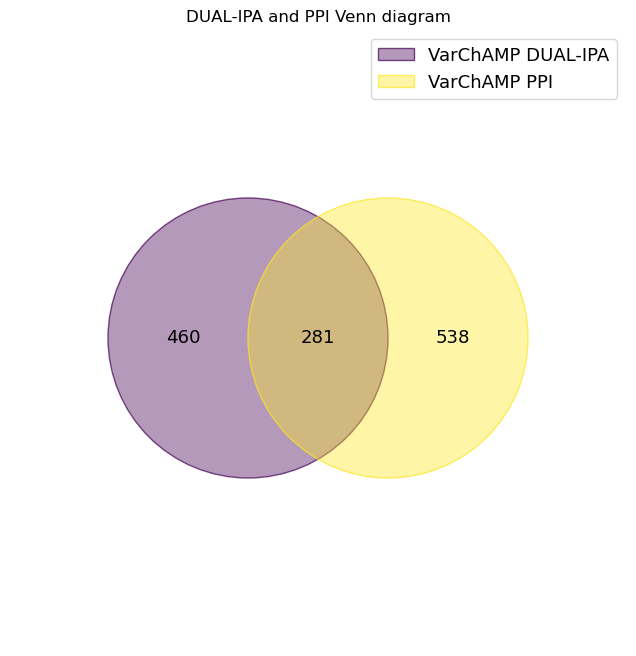

In [6]:
dual_ipa_df = pl.read_csv("../1_inputs/dual_ipa/abun_scores.csv", infer_schema_length=1000000)
display(dual_ipa_df)
print("VarChAMP DUAL-IPA assay unique variants:", dual_ipa_df.unique(subset=["gene_variant"]).shape[0])
ppi_sum_df = pl.read_csv("../1_inputs/ppi/edgotyping_perturb_sum_stats.csv", infer_schema_length=1000000)
display(ppi_sum_df)
print("VarChAMP DUAL-IPA assay unique variants:", ppi_sum_df.unique(subset=["gene_variant"]).shape[0])

## merge the two assays by gene_variant
dual_ppi_df = dual_ipa_df.join(
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)
print("VarChAMP DUAL-IPA and PPI assay unique variants:", dual_ppi_df.unique(subset=["gene_variant"]).shape[0])

dual_ppi_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
}

venn(dual_ppi_set)
plt.title("DUAL-IPA and PPI Venn diagram")
plt.show()

<Axes: xlabel='zscore_log2', ylabel='perturbed_percentage'>

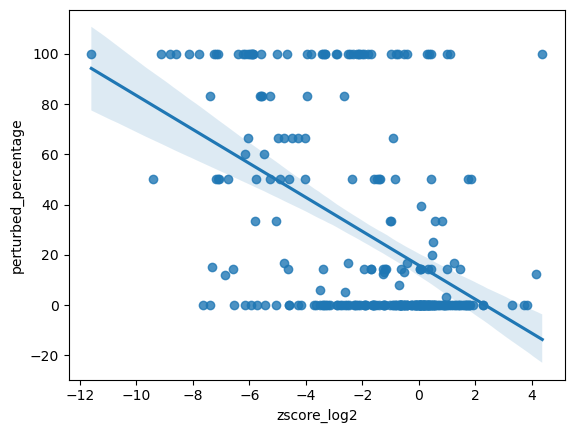

In [18]:
sns.regplot(data=dual_ppi_df.to_pandas(),
            x="zscore_log2",
            y="perturbed_percentage")

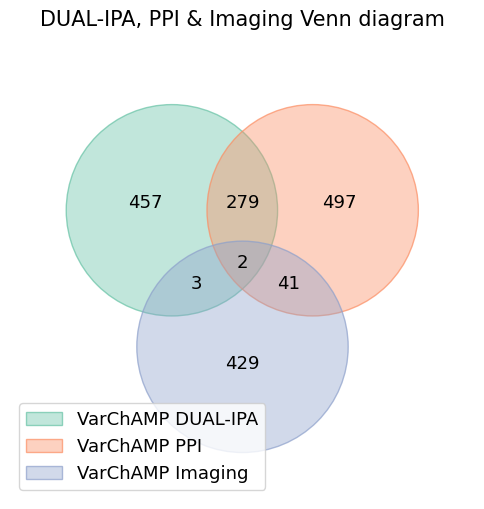

In [9]:
# Create the diagrams with your data
dual_ppi_img_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique())
}
venn(dual_ppi_img_set, figsize=(6,8), legend_loc="lower left", 
     cmap=sns.color_palette("Set2") ## dict(zip(dual_ppi_img_set.keys(), sns.color_palette("Set2"))
)
plt.title("DUAL-IPA, PPI & Imaging Venn diagram", fontsize=15, y=1.)
plt.show()

In [10]:
img_dual_ppi_df = img_metric_df.join( ## .unique(subset=["gene_variant"])
    dual_ipa_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_dualipa"
).join( ## .unique(subset=["gene_variant"])
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)

img_dual_ppi_df = img_dual_ppi_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
)
img_dual_ppi_df.unique("gene_variant")

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,symbol,ensembl_gene_id,orf_id,mut_id,…,Naive_prior_prob_PMID:31131967_ppi,Calcualted_post_prob_PMID:31131967_ppi,calculated_classification_PMID:31131967_ppi,SGR LR_PMID:34273903_ppi,Personal and Family History LR (Combined)_PMID:34273903_ppi,Breast Tumor Pathology LR_PMID:34273903_ppi,Population Allele Frequency LR_PMID:34273903_ppi,BS2 LR_PMID:34273903_ppi,Calculated_combined_LR_PMID:34273903_ppi,Naive_prior_prob_PMID:34273903_ppi,Calculated_post_prob_PMID:34273903_ppi,calculated_classification_PMID:34273903_ppi,Reference Group*_presumed_PMID:34273903_ppi,Component_presumed_PMID:34273903_ppi,Rationale_presumed_PMID:34273903_ppi,ClinVar Variation Id_ClinGen_repo_ppi,Allele Registry Id_ClinGen_repo_ppi,Disease_ClinGen_repo_ppi,Mondo Id_ClinGen_repo_ppi,Mode of Inheritance_ClinGen_repo_ppi,Assertion_ClinGen_repo_ppi,Applied Evidence Codes (Met)_ClinGen_repo_ppi,Applied Evidence Codes (Not Met)_ClinGen_repo_ppi,Summary of interpretation_ClinGen_repo_ppi,PubMed Articles_ClinGen_repo_ppi,Expert Panel_ClinGen_repo_ppi,Guideline_ClinGen_repo_ppi,Approval Date_ClinGen_repo_ppi,Published Date_ClinGen_repo_ppi,Retracted_ClinGen_repo_ppi,Evidence Repo Link_ClinGen_repo_ppi,Uuid_ClinGen_repo_ppi,Updated_Classification_ClinGen_repo_ppi,Updated_Evidence Codes_ClinGen_repo_ppi,gene_variant_pp_ppi,aa_change_pp_ppi,pillar_tested_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,str,str,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""HMBS""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""HMBS_Glu86Val""","""Glu86Val""",true
"""FH""","""FH_Leu507Pro""",4.283742,0.005184,-9.275306,0.000035,"""2025_01_Batch_13-14""",0.923323,0.941709,0.991051,0.978264,0.819045,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,0.0,0.0,true,"""FH""",null,3408,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""SOS2""","""SOS2_Pro1318Ser""",1.049312,0.328906,9.648726,0.000027,"""2025_01_Batch_13-14""",0.55434,0.688724,0.870454,0.745989,0.581127,0.67221,0.810049,0.953618,0.910308,0.673086,0.613275,0.749387,0.912036,0.828148,0.627106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""SOS 2""",null,55187,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""FARS2""","""FARS2_Tyr144Cys""",-0.319834,1.0,-0.942477,1.0,"""2025_01_Batch_13-14""",0.641907,0.723691,0.667994,0.743307,0.492749,0.75153,0.649669,0.640087,0.782555,0.636371,0.696719,0.68668,0.65404,0.762931,0.56456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""FARS2""",null,12653,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null

In [11]:
img_dual_ppi_df.filter(pl.col("gene_variant").str.contains("XRCC2"))["gene_variant"]

gene_variant
str
"""XRCC2_Phe270Val"""


In [22]:
img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))&(pl.col("dualipa_assayed")))

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,…,Naive_prior_prob_PMID:31131967_ppi,Calcualted_post_prob_PMID:31131967_ppi,calculated_classification_PMID:31131967_ppi,SGR LR_PMID:34273903_ppi,Personal and Family History LR (Combined)_PMID:34273903_ppi,Breast Tumor Pathology LR_PMID:34273903_ppi,Population Allele Frequency LR_PMID:34273903_ppi,BS2 LR_PMID:34273903_ppi,Calculated_combined_LR_PMID:34273903_ppi,Naive_prior_prob_PMID:34273903_ppi,Calculated_post_prob_PMID:34273903_ppi,calculated_classification_PMID:34273903_ppi,Reference Group*_presumed_PMID:34273903_ppi,Component_presumed_PMID:34273903_ppi,Rationale_presumed_PMID:34273903_ppi,ClinVar Variation Id_ClinGen_repo_ppi,Allele Registry Id_ClinGen_repo_ppi,Disease_ClinGen_repo_ppi,Mondo Id_ClinGen_repo_ppi,Mode of Inheritance_ClinGen_repo_ppi,Assertion_ClinGen_repo_ppi,Applied Evidence Codes (Met)_ClinGen_repo_ppi,Applied Evidence Codes (Not Met)_ClinGen_repo_ppi,Summary of interpretation_ClinGen_repo_ppi,PubMed Articles_ClinGen_repo_ppi,Expert Panel_ClinGen_repo_ppi,Guideline_ClinGen_repo_ppi,Approval Date_ClinGen_repo_ppi,Published Date_ClinGen_repo_ppi,Retracted_ClinGen_repo_ppi,Evidence Repo Link_ClinGen_repo_ppi,Uuid_ClinGen_repo_ppi,Updated_Classification_ClinGen_repo_ppi,Updated_Evidence Codes_ClinGen_repo_ppi,gene_variant_pp_ppi,aa_change_pp_ppi,pillar_tested_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""GSS""","""GSS_Arg125Cys""",null,null,null,null,"""2025_01_Batch_13-14""",0.602072,0.653072,0.763212,0.7237,0.566457,0.539237,0.619455,0.548967,0.649187,0.499309,0.570654,0.636264,0.656089,0.686444,0.532883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,5132,215352,"""GSS""","""Arg125Cys""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""BCL10""","""BCL10_Leu8Leu""",1.593538,0.186262,-1.852878,0.106317,"""2025_01_Batch_13-14""",0.535754,0.635298,0.663309,0.691869,0.493863,0.882353,0.759233,0.764702,0.821239,0.579186,0.709053,0.697265,0.714005,0.756554,0.536524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,11832,20121,"""BCL10""","""Leu8Leu""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [100]:
pillar_varchamp_df.filter(pl.col("gene_variant").str.contains("XRCC2_Phe270Val"))#.unique("")

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,SomaticClinicalImpact,SomaticClinicalImpactLastEvaluated,ReviewStatusClinicalImpact,Oncogenicity,OncogenicityLastEvaluated,ReviewStatusOncogenicity,SCVsForAggregateGermlineClassification,SCVsForAggregateSomaticClinicalImpact,SCVsForAggregateOncogenicityClassification,clinvar_nt_change,clinvar_aa_change,RefSeq_mRNA,StarStatus,clinvar_clnsig_clean,chr,chr_pos_38,ref_right,alt_right,gnomad_af,varchamp_collection
i64,str,str,str,f64,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,i64,i64,str,str,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,i64,str,str,f64,bool


In [23]:
img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).group_by("Gene").agg(
    pl.col("Gene").len().alias("Count")
)

Gene,Count
str,u32
"""FARS2""",9
"""SDHD""",14
"""GSS""",1
"""RAD51D""",14
"""CTCF""",4
"""BCL10""",1


<Axes: xlabel='AUROC_Mean_Morph', ylabel='perturbed_percentage'>

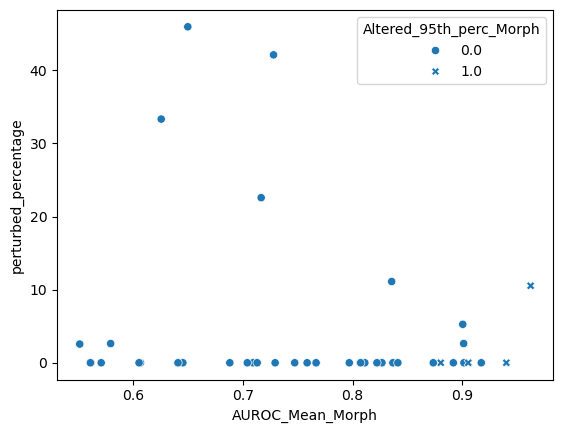

In [24]:
sns.scatterplot(data=img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).to_pandas(),
                x="AUROC_Mean_Morph",
                y="perturbed_percentage",
                style="Altered_95th_perc_Morph")

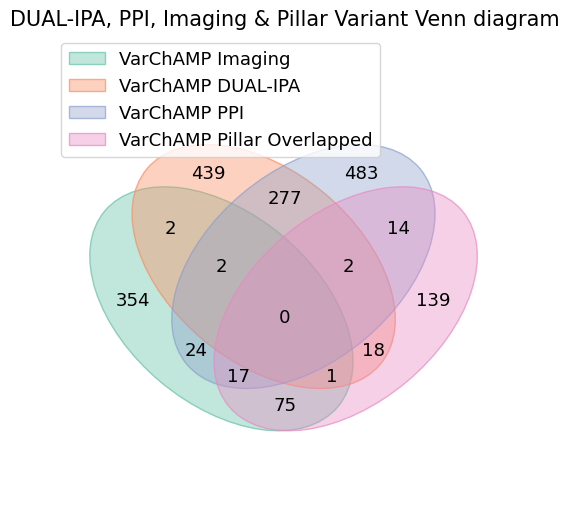

In [40]:
# Create the diagrams with your data
sets_data = {
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'VarChAMP Pillar Overlapped': set(varchamp_pillar_df.filter(pl.col("pillar_tested"))["gene_variant"].unique()),
}

venn(sets_data, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Variant Venn diagram", fontsize=15, y=1.)
plt.show()

In [20]:
pillar_varchamp_df_variant_reannot = pillar_varchamp_df.with_columns(
    pl.when((pl.col("varchamp_collection")))
    .then(pl.col("gene_variant_vc"))
    .otherwise(pl.col("gene_variant"))
    .alias("gene_variant")
)

In [92]:
ppi_sum_df.filter(pl.col("symbol")=="XRCC2")

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,i64,i64,i64,i64,f64,f64,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""XRCC2_Phe270Val""",2,1,0,0,50.0,0.0,0.0,true,"""XRCC2""","""ENSG00000196584""",13571,218098,"""CCSBVarC005690""","""ALE00005690""","""NC_000007.14:152648677:A:C""","""808T>G""","""Phe270Val""","""CEGS2""","""CegsMutGDEh1030""","""D06""","""GDEhDisVCh_40090""","""A05""","""2""","""CegsMutGDDh1030""","""D06""","""VUSN2Hmut_GDN2h_05""","""D04""","""VUSMutpDEST2_11""","""H04""","""VUSmut_GDEh05""","""D04""",1,1,1,1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [90]:
img_dual_ppi_df

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,symbol,ensembl_gene_id,orf_id,mut_id,…,Naive_prior_prob_PMID:31131967_ppi,Calcualted_post_prob_PMID:31131967_ppi,calculated_classification_PMID:31131967_ppi,SGR LR_PMID:34273903_ppi,Personal and Family History LR (Combined)_PMID:34273903_ppi,Breast Tumor Pathology LR_PMID:34273903_ppi,Population Allele Frequency LR_PMID:34273903_ppi,BS2 LR_PMID:34273903_ppi,Calculated_combined_LR_PMID:34273903_ppi,Naive_prior_prob_PMID:34273903_ppi,Calculated_post_prob_PMID:34273903_ppi,calculated_classification_PMID:34273903_ppi,Reference Group*_presumed_PMID:34273903_ppi,Component_presumed_PMID:34273903_ppi,Rationale_presumed_PMID:34273903_ppi,ClinVar Variation Id_ClinGen_repo_ppi,Allele Registry Id_ClinGen_repo_ppi,Disease_ClinGen_repo_ppi,Mondo Id_ClinGen_repo_ppi,Mode of Inheritance_ClinGen_repo_ppi,Assertion_ClinGen_repo_ppi,Applied Evidence Codes (Met)_ClinGen_repo_ppi,Applied Evidence Codes (Not Met)_ClinGen_repo_ppi,Summary of interpretation_ClinGen_repo_ppi,PubMed Articles_ClinGen_repo_ppi,Expert Panel_ClinGen_repo_ppi,Guideline_ClinGen_repo_ppi,Approval Date_ClinGen_repo_ppi,Published Date_ClinGen_repo_ppi,Retracted_ClinGen_repo_ppi,Evidence Repo Link_ClinGen_repo_ppi,Uuid_ClinGen_repo_ppi,Updated_Classification_ClinGen_repo_ppi,Updated_Evidence Codes_ClinGen_repo_ppi,gene_variant_pp_ppi,aa_change_pp_ppi,pillar_tested_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,str,str,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""CCM2""","""CCM2_Arg40Cys""",-0.099545,1.0,6.13221,1.0,"""2025_01_Batch_13-14""",0.863261,0.814502,0.829017,0.77641,0.829125,0.966312,0.897839,0.869486,0.92901,0.904504,0.914787,0.856171,0.849251,0.85271,0.866814,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,true,"""CCM2""",null,3928,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""FARS2""","""FARS2_Gly309Ser""",0.947712,1.0,-3.676692,0.008972,"""2025_01_Batch_13-14""",0.887019,0.899865,0.935146,0.905768,0.714368,0.568663,0.774402,0.885462,0.765493,0.558448,0.727841,0.837134,0.910304,0.835631,0.636408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""FARS2""",null,12653,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""CCM2""","""CCM2_Arg19Gln""",-0.237168,1.0,10.201014,0.00004,"""2025_01_Batch_13-14""",0.825823,0.894746,0.961375,0.888694,0.797074,0.820411,0.93383,0.983412,0.950203,0.795231,0.823117,0.914288,0.972393,0.919449,0.796153,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""CCM2""",null,3928,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""CCM2""","""CCM2_Glu51Ala""",4.75288,1.0,6.640781,0.008316,"""2025_01_Batch_13-14""",0.83473,0.791342,0.817977,0.818589,0.818436,0.76784,0.881877,0.921666,0.849881,0.759391,0.801285,0.836609,0.869821,0.834235,0.788914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,"""CCM2""",null,3928,null,…,null,null,null,null,nul

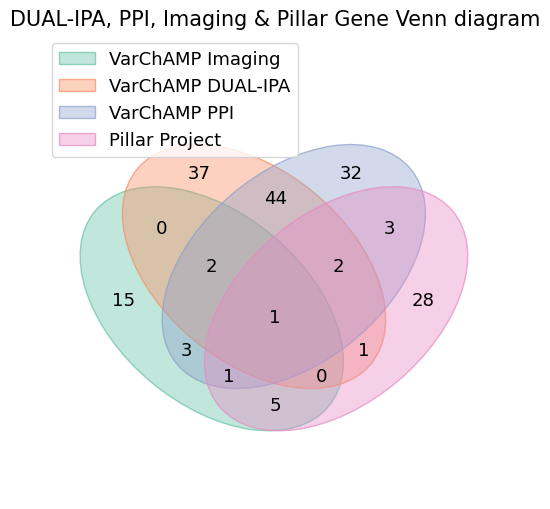

In [85]:
# Create the diagrams with your data
sets_data_gene_all_pillar = {
    'VarChAMP Imaging': set(img_metric_df["symbol"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["symbol"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["symbol"].unique()),
    'Pillar Project': set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["Gene"].unique()),
}

venn(sets_data_gene_all_pillar, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Gene Venn diagram", fontsize=15, y=1.)
plt.show()

In [88]:
# Method 1: using set.intersection
common_genes = set.intersection(set(img_metric_df["symbol"].unique()).union(set(dual_ipa_df["symbol"].unique())).union(set(ppi_sum_df["symbol"].unique())),
                                set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["Gene"].unique()))
common_genes

{'BAP1',
 'BRCA1',
 'CTCF',
 'F9',
 'G6PD',
 'GCK',
 'HMBS',
 'MSH2',
 'RAD51D',
 'RHO',
 'TPK1',
 'VHL',
 'XRCC2'}

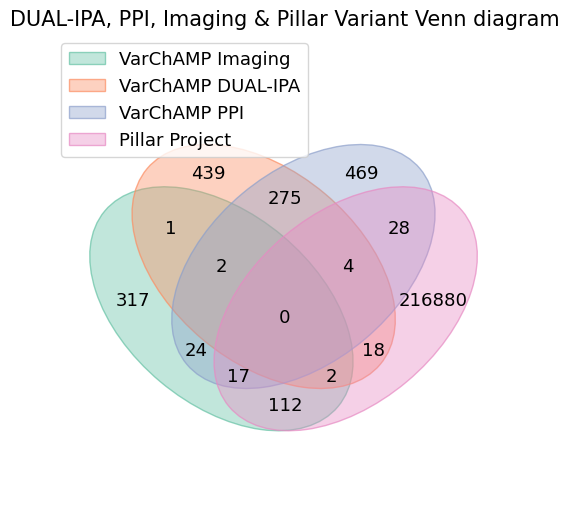

In [21]:
# Create the diagrams with your data
sets_data_variant_all_pillar = {
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'Pillar Project': set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"].unique()),
}


venn(sets_data_variant_all_pillar, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Variant Venn diagram", fontsize=15, y=1.)
plt.show()

In [25]:
set(ppi_sum_df.filter(pl.col("gene_variant").str.contains("RAD51D"))["gene_variant"].unique()).intersection(
    set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"].unique())
)

{'RAD51D_Ala231Ser',
 'RAD51D_Cys9Ser',
 'RAD51D_Glu307Lys',
 'RAD51D_Gly289Ser',
 'RAD51D_His23Arg',
 'RAD51D_Ile251Val',
 'RAD51D_Met308Val',
 'RAD51D_Phe305Leu',
 'RAD51D_Thr328Ile',
 'RAD51D_Val132Ile',
 'RAD51D_Val28Leu',
 'RAD51D_Val56Gly',
 'RAD51D_Val66Leu',
 'RAD51D_Val66Met'}

In [26]:
len(set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"].unique()))

217061

In [64]:
# # Create the diagrams with your data
# sets_data_gene = {
#     'VarChAMP Imaging': set(img_metric_df["symbol"].unique()), 
#     'VarChAMP DUAL-IPA': set(dual_ipa_df["symbol"].unique()),
#     'VarChAMP PPI': set(ppi_sum_df["symbol"].unique()),
#     'VarChAMP Pillar Overlapped': set(varchamp_pillar_df.filter(pl.col("pillar_tested"))["symbol"].unique()),
# }
# venn(sets_data_gene, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
# plt.title("DUAL-IPA, PPI, Imaging & Pillar Gene Venn diagram", fontsize=15, y=1.)
# plt.show()

In [ ]:
g = sns.catplot(data=img_dual_ppi_df.filter(
    (pl.col("Gene").is_in(pillar_clinvar_df["Gene"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
).unique(
    "gene_variant"
).group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=6, aspect=.9)
plt.title("Number of Overlapped Variants per Gene in Pillar Project dataset")

In [12]:
g = sns.catplot(data=img_dual_ppi_df.filter(
    (pl.col("gene_variant").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
).unique(
    "gene_variant"
).group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=6, aspect=.9)
plt.title("Number of Overlapped Variants per Gene in Both Collections")

NameError: name 'pillar_varchamp_df_variant_reannot' is not defined

## 2. Functional Assay Mapping

In [26]:
def plot_gene_level_summary(df, hit_col, cell_change, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # sort by total_variants descending just for nicer plotting order
        .sort("len", descending=False)
    ).to_pandas()
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.4
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=10 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["Gene"],
        fontsize=10 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
    ax.legend(fontsize=11, loc="lower right")